In [1]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import os.path
import time, itertools, re
from collections import Counter
from sklearn.inspection import permutation_importance
import miceforest as mf
from sklearn.metrics import confusion_matrix, r2_score, root_mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegressionCV, LassoCV, LogisticRegression
import importlib
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
print(os.getcwd())
fileloc_data='/'.join(os.getcwd().split('/')[0:5])+ '/data/annonymizedDatasets/'
savetag='pred_lavSQ_MHC'
print(fileloc_data)
code_path='/'.join(os.getcwd().split('/')[0:4])+'/sklvq/'
sys.path.append(code_path)
from sklvq import GMLVQ, LGMLVQ
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis,)
from sklearn.svm import SVC, SVR
from EDdataset_GGZ import colsTypeCast  
from HypOpt import lowest_cwacc
df_all_combo=pd.read_csv(fileloc_data+'maskedDAIsy_MainDect_ED_SQ48_MHC_Honos_Lav.tsv', sep='\t', decimal=',')
df_adapted_combo, colsExtracted, subscales=colsTypeCast(df_all_combo)
adapted_combo_cols=np.setdiff1d(colsExtracted,
        ['ED_Codes','EDtype', 'SQ48-Score', 'MHCSF-Score', 'Lav-Score']+list(subscales['Honos'])+list(subscales['EDEQ']))
print(adapted_combo_cols)

/home/sreejita/ProjectsPy/GGZ/code_scripts/ED-profiling
/home/sreejita/ProjectsPy/GGZ/data/annonymizedDatasets/
['DT-BMI' 'DT-Disorder_Duration_Yrs' 'DT-IND_BDL_CMD' 'DT-IND_OCD_CMD'
 'DT-IND_depression_CMD' 'DT-IND_others' 'DT-IND_prev_spec_int_wo_eff'
 'DT-num_prev_routes' 'Lav-Dissatisfaction_body'
 'Lav-Negative_appraisal_body' 'Lav-Unfamiliarity_with_body'
 'MHCSF-Emotional_Well-being' 'MHCSF-Psychological_Well-being'
 'MHCSF-Social_Well-being' 'Main-Age' 'Main-Biosex' 'Main-Education'
 'SQ48-Agoraphobia' 'SQ48-Anxiety' 'SQ48-Cognitive_Complaints'
 'SQ48-Depression' 'SQ48-Hostility' 'SQ48-Social_phobia'
 'SQ48-Somatic_Complaints' 'SQ48-Vitality' 'SQ48-Work_related_complaints']


In [2]:
%load_ext autoreload

# Classification

In [3]:
from GetDataReady import getDataNormalized

/home/sreejita/ProjectsPy/GGZ/code_scripts/ED-profiling


## All classes

In [4]:
choice_dict={1.0: 'Core-DT, 5Cls', 1.1: 'Core-DT, only ED', 1.2: 'Core-DT, 3 ED and Others',
    2.0: 'Core-DT-EDEQ subscale, 5Cls', 2.1: 'Core-DT-EDEQ subscale, only ED', 2.2: 'Core-DT-EDEQ subscale, 3 ED and Others',
    3.0: 'Core, 5Cls', 3.1: 'Core, only ED', 3.2: 'Core, 3 ED and Others'}
save_dict={1.0: 'Core-DT-5Cls', 1.1: 'Core-DT-onlyED', 1.2: 'Core-DT-3ED-Others',
    2.0: 'Core-DT-EDEQ-5Cls', 2.1: 'Core-DT-EDEQ-only-ED', 2.2: 'Core-DT-EDEQ-3ED-Others',
    3.0: 'Core-5Cls', 3.1: 'Core-onlyED', 3.2: 'Core-3ED-Others'}
dataset_types={}
for key, val in choice_dict.items():
    dataset_types[key]=getDataNormalized(key)

1.0: For dataset with Core, DT, and 5 classes (Ndims=24):

1.1: For dataset with Core, DT and only ED classes:

1.2: For dataset with Core, DT and 3 ED classes and Others:

2.0: For dataset with Core, DT, EDEQ subscales and all 5 classes (Ndim=27):

2.1: For dataset with Core, DT, EDEQ subscales, and only ED classes:

2.2: For dataset with Core, DT, EDEQ subscales and 3 ED classes and Others:

3.0: For dataset with Core only, and all 5 classes (Ndim=16):

3.1: For dataset with Core only, and only ED classes:

3.2: For dataset with Core, and 3 ED classes and Others:



In [94]:
print(X.shape, num_features, all_ftr_vars.shape)

(97, 26) 26 (26, 5)


In [90]:
iters, nreps=5,10
fimp_all_exps, labs_all, prots_lvq_all={},{},{}
train_conf_all_Exps, test_conf_all_Exps, classifiers_all_Exps={},{},{}
use_permutation_imp=['KNN','LDA','QDA','LSVC','RSVC']
savepicklpath='%s/pickles/'%(os.getcwd())
for keyData, valData in choice_dict.items():
    train_conf_all, test_conf_all, classifiers_all={},{},{}
    dataset_type=save_dict[keyData]#'Core_DT'#save_dict[choice]
    YTrain, YTest=dataset_types[keyData]['Ytrain'], dataset_types[keyData]['Ytest']  
    if keyData>=3:        
        zXTrain, zXTest=dataset_types[keyData]['zXtrain'], dataset_types[keyData]['zXtest']  
    else:
        zXTrain, zXTest=dataset_types[keyData]['mice_zXtrain'], dataset_types[keyData]['mice_zXtest']
    labs_all[keyData]=np.unique(YTrain)
    num_features, nclasses, labs=zXTrain.shape[1], len(np.unique(YTrain)), np.unique(YTrain)
    model_fname='cls-%s.pkl'%dataset_type
    modelsClassify='%s%s'%(savepicklpath, model_fname)
    modelsClassify_permut='%s%s_%s.pkl'%(savepicklpath,dataset_type, 'FtrImp')       
    if os.path.exists(modelsClassify):
        pipeClassifiers = pickle.load(open(modelsClassify, "rb"))
        permut_model=pickle.load(open('%s'%modelsClassify_permut, "rb"))
        print('Loading final %s Classification models complete'%valData)          
        use_permutation_imp, nreps, prots_lvq, fimp_clf=list(permut_model.keys()),10,{},{}
        for keyClf, clf in pipeClassifiers.items():                        
            tr_cmap, te_cmap=np.zeros((nclasses, nclasses, iters)), np.zeros((nclasses, nclasses, iters))            
            if (keyClf=='GMLVQ') | (keyClf=='LGMLVQ'):    
                all_prots=np.zeros((clf[0][keyClf].prototypes_.shape[0], num_features, iters))
            if (keyClf=='LGMLVQ') | (keyClf=='GNB') | (keyClf=='LogLASSO'):
                all_ftr_vars=np.zeros((nclasses, num_features, iters))
            elif keyClf in use_permutation_imp:
                all_ftr_vars=np.zeros((num_features,nreps, iters))    
            else:
                all_ftr_vars=np.zeros((num_features, iters))   
            for iter in range(iters):  
                if keyClf=='GMLVQ':
                    all_ftr_vars[:,iter]=np.diagonal(clf[iter][keyClf].lambda_)
                elif keyClf=='RF':
                    all_ftr_vars[:,iter]=clf[iter][keyClf].feature_importances_
                elif keyClf=='LGMLVQ':
                    cwRel=[]
                    for x in range(nclasses): cwRel.append(np.diagonal(clf[iter][keyClf].lambda_[x]))
                    all_ftr_vars[:,:,iter]=cwRel
                elif (keyClf=='GNB'):                    
                    all_ftr_vars[:,:,iter]=clf[iter][keyClf].var_
                elif keyClf=='LogLASSO':
                    cwRel=[]
                    for x in range(nclasses): cwRel.append(np.abs(clf[iter][keyClf].coef_[x]))                    
                    all_ftr_vars[:,:,iter]=cwRel#clf[iter][key].coef_.abs()#[np.where(clf[iter].Cs_==clf[iter].C_)[0]].abs()
                else:
                    all_ftr_vars[:,:,iter]=permut_model[keyClf][iter]
                if (keyClf=='GMLVQ') | (keyClf=='LGMLVQ'):    
                    all_prots[:,:,iter]=clf[iter][keyClf].prototypes_            
                train_pred_labs=clf[iter][keyClf].predict(zXTrain)
                test_pred_labs=clf[iter][keyClf].predict(zXTest)
                tr_cmap[:,:,iter]=confusion_matrix(YTrain, train_pred_labs, normalize='true', labels=labs)
                te_cmap[:,:,iter]=confusion_matrix(YTest, test_pred_labs, normalize='true', labels=labs)
                train_conf_all[keyClf], test_conf_all[keyClf]=tr_cmap, te_cmap
            if keyClf in ['GMLVQ','LGMLVQ']:
                prots_lvq[keyClf]={'Mean': np.mean(all_prots,axis=2), 'Std': np.std(all_prots,axis=2),
                               'All':all_prots}
            if keyClf in use_permutation_imp:
                n_extended=all_ftr_vars.shape[1]* all_ftr_vars.shape[2]
                all_ftr_vars=np.reshape(all_ftr_vars,(num_features, n_extended))
                all_ftr_vars[all_ftr_vars<0.0]=0.0
                fimp_all[keyClf]={'Mean': np.mean(all_ftr_vars, axis=1), 'Std':np.std(all_ftr_vars, axis=1),
                              'All': all_ftr_vars}
            elif keyClf in ['RF', 'GMLVQ']:
                fimp_all[keyClf]={'Mean': np.mean(all_ftr_vars, axis=1), 'Std':np.std(all_ftr_vars, axis=1),
                              'All': all_ftr_vars}
            else:
                perClass={}
                for c in range(nclasses):
                    perClass['C%d'%(c+1)]={'Mean': np.mean(all_ftr_vars[c,:,:]),
                         'Std': np.std(all_ftr_vars[c,:,:]),'All': all_ftr_vars[c,:,:]}
                fimp_all[keyClf]=perClass
            del all_ftr_vars
    print(np.shape(fimp_all['RF']['All']))
    fimp_all_exps[keyData]=fimp_all.copy()
    prots_lvq_all[keyData]=prots_lvq.copy()        
    train_conf_all_Exps[keyData]=train_conf_all.copy()
    test_conf_all_Exps[keyData]=test_conf_all.copy()
    #classifiers_all_Exps[keyData]=classifiers_all

Loading final Core-DT, 5Cls Classification models complete
(24, 5)
Loading final Core-DT, only ED Classification models complete
(24, 5)
Loading final Core-DT, 3 ED and Others Classification models complete
(24, 5)
Loading final Core-DT-EDEQ subscale, 5Cls Classification models complete
(27, 5)
Loading final Core-DT-EDEQ subscale, only ED Classification models complete
(27, 5)
Loading final Core-DT-EDEQ subscale, 3 ED and Others Classification models complete
(27, 5)
Loading final Core, 5Cls Classification models complete
(16, 5)
Loading final Core, only ED Classification models complete
(16, 5)
Loading final Core, 3 ED and Others Classification models complete
(16, 5)


In [91]:
prots_lvq_all

{1.0: {'LGMLVQ': {'Mean': array([[-8.63315920e-01, -2.58417037e-01, -5.69652749e-02,
            3.13127423e-01,  1.01690411e-02,  3.30977552e-02,
            2.95160458e-01, -2.25524417e-01,  4.17643728e-02,
           -3.05946836e-01,  1.67139428e-01, -2.69104949e-01,
           -2.47999620e-01,  1.94965411e-02, -1.81786225e-01,
            3.64077926e-02,  2.96166703e-01,  1.21989322e-01,
            3.26070207e-01,  2.45530179e-02,  7.34706408e-02,
            3.88883514e-01,  2.13970003e-01, -7.20391646e-02],
          [-3.80809857e-01, -4.29003842e-01, -5.36804401e-02,
            3.14629222e-01, -7.24009802e-02, -3.93314869e-02,
            1.61525143e-01, -1.56223377e-01,  5.29607206e-02,
           -2.78056899e-01,  2.20834760e-01,  1.01144879e-03,
           -4.75694575e-02, -1.32288338e-01, -3.27384735e-01,
           -5.32200048e-02, -5.79451931e-02,  2.37566624e-02,
            1.29674232e-01, -1.20365881e-01,  1.91572661e-01,
            1.44534480e-01,  1.23037739e-02, -

### Core+ Detools

In [67]:
for keyData in [1.0,1.1,1.2]:
    train_conf_all=train_conf_all_Exps[keyData]
    test_conf_all=test_conf_all_Exps[keyData]
    labs=labs_all[keyData]
    print(choice_dict[keyData])
    for keyClf, val in train_conf_all.items(): 
        cmap_dict={'Training': train_conf_all[keyClf], 'Test':test_conf_all[keyClf]}
        nclasses=len(labs)
        #labs=pipeClassifiers_
        for split_set in ['Training', 'Test']:
            if split_set=='Test':
                print(keyClf+'-'+split_set)    
            if split_set=='Training':
                printlabs=[]
                for lab in labs:
                    if len(labs)>4:                        
                        if (lab==labs[2]) | (lab==labs[4]):
                            printlabs.append('    '+lab)
                        else:
                            printlabs.append(lab)
                    else:
                         if (lab==labs[2]):
                            printlabs.append('    '+lab)
                         else:
                            printlabs.append(lab)
                print(printlabs)
            mean_glob, std_glob=cmap_dict[split_set].mean(axis=2), cmap_dict[split_set].std(axis=2)
            disp_num_glob=np.reshape(np.stack((mean_glob, std_glob)).ravel('F'),(nclasses,2*nclasses))
            if split_set=='Test':
                for idx in range(nclasses):
                    cmap_cell=[]
                    for jdx in range(nclasses):
                        cmap_cell.append('%.3f (%.3f) '%(mean_glob[idx,jdx], std_glob[idx,jdx]))
                    print(cmap_cell) 

Core-DT, 5Cls
['Anorexia nervosa', 'Binge-ED', '    Bulimia nervosa', 'Other ED', '    Others']
RF-Test
['0.750 (0.000) ', '0.100 (0.000) ', '0.050 (0.000) ', '0.100 (0.000) ', '0.000 (0.000) ']
['0.200 (0.000) ', '0.800 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ']
['0.556 (0.000) ', '0.222 (0.000) ', '0.111 (0.000) ', '0.111 (0.000) ', '0.000 (0.000) ']
['0.700 (0.000) ', '0.100 (0.000) ', '0.100 (0.000) ', '0.100 (0.000) ', '0.000 (0.000) ']
['0.600 (0.000) ', '0.400 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ']
['Anorexia nervosa', 'Binge-ED', '    Bulimia nervosa', 'Other ED', '    Others']
KNN-Test
['0.800 (0.000) ', '0.050 (0.000) ', '0.100 (0.000) ', '0.000 (0.000) ', '0.050 (0.000) ']
['0.200 (0.000) ', '0.600 (0.000) ', '0.100 (0.000) ', '0.100 (0.000) ', '0.000 (0.000) ']
['0.444 (0.000) ', '0.111 (0.000) ', '0.222 (0.000) ', '0.000 (0.000) ', '0.222 (0.000) ']
['0.800 (0.000) ', '0.100 (0.000) ', '0.000 (0.000) ', '0.100 (0.000) ', '0.0

### Core + Dectools + EDEQ

In [68]:
for keyData in [2.0,2.1,2.2]:
    train_conf_all=train_conf_all_Exps[keyData]
    test_conf_all=test_conf_all_Exps[keyData]
    labs=labs_all[keyData]
    print(choice_dict[keyData])
    for keyClf, val in train_conf_all.items(): 
        cmap_dict={'Training': train_conf_all[keyClf], 'Test':test_conf_all[keyClf]}
        nclasses=len(labs)
        #labs=pipeClassifiers_
        for split_set in ['Training', 'Test']:
            if split_set=='Test':
                print(keyClf+'-'+split_set)    
            if split_set=='Training':
                printlabs=[]
                for lab in labs:
                    if len(labs)>4:                        
                        if (lab==labs[2]) | (lab==labs[4]):
                            printlabs.append('    '+lab)
                        else:
                            printlabs.append(lab)
                    else:
                         if (lab==labs[2]):
                            printlabs.append('    '+lab)
                         else:
                            printlabs.append(lab)
                print(printlabs)
            mean_glob, std_glob=cmap_dict[split_set].mean(axis=2), cmap_dict[split_set].std(axis=2)
            disp_num_glob=np.reshape(np.stack((mean_glob, std_glob)).ravel('F'),(nclasses,2*nclasses))
            if split_set=='Test':
                for idx in range(nclasses):
                    cmap_cell=[]
                    for jdx in range(nclasses):
                        cmap_cell.append('%.3f (%.3f) '%(mean_glob[idx,jdx], std_glob[idx,jdx]))
                    print(cmap_cell) 

Core-DT-EDEQ subscale, 5Cls
['Anorexia nervosa', 'Binge-ED', '    Bulimia nervosa', 'Other ED', '    Others']
RF-Test
['0.900 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ', '0.100 (0.000) ', '0.000 (0.000) ']
['0.200 (0.000) ', '0.700 (0.000) ', '0.000 (0.000) ', '0.100 (0.000) ', '0.000 (0.000) ']
['0.556 (0.000) ', '0.333 (0.000) ', '0.000 (0.000) ', '0.111 (0.000) ', '0.000 (0.000) ']
['0.200 (0.000) ', '0.100 (0.000) ', '0.200 (0.000) ', '0.500 (0.000) ', '0.000 (0.000) ']
['0.600 (0.000) ', '0.400 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ']
['Anorexia nervosa', 'Binge-ED', '    Bulimia nervosa', 'Other ED', '    Others']
KNN-Test
['0.650 (0.000) ', '0.000 (0.000) ', '0.050 (0.000) ', '0.150 (0.000) ', '0.150 (0.000) ']
['0.600 (0.000) ', '0.200 (0.000) ', '0.000 (0.000) ', '0.200 (0.000) ', '0.000 (0.000) ']
['0.556 (0.000) ', '0.111 (0.000) ', '0.111 (0.000) ', '0.000 (0.000) ', '0.222 (0.000) ']
['0.300 (0.000) ', '0.200 (0.000) ', '0.300 (0.000) ', '0.200 (

### Only the Core dataset

In [34]:
for keyData in [3.0,3.1,3.2]:
    train_conf_all=train_conf_all_Exps[keyData]
    test_conf_all=test_conf_all_Exps[keyData]
    labs=labs_all[keyData]
    print(choice_dict[keyData])
    for keyClf, val in train_conf_all.items(): 
        cmap_dict={'Training': train_conf_all[keyClf], 'Test':test_conf_all[keyClf]}
        nclasses=len(labs)
        #labs=pipeClassifiers_
        for split_set in ['Training', 'Test']:
            if split_set=='Test':
                print(keyClf+'-'+split_set)    
            if split_set=='Training':
                printlabs=[]
                for lab in labs:
                    if len(labs)>4:                        
                        if (lab==labs[2]) | (lab==labs[4]):
                            printlabs.append('    '+lab)
                        else:
                            printlabs.append(lab)
                    else:
                         if (lab==labs[2]):
                            printlabs.append('    '+lab)
                         else:
                            printlabs.append(lab)
                print(printlabs)
            mean_glob, std_glob=cmap_dict[split_set].mean(axis=2), cmap_dict[split_set].std(axis=2)
            disp_num_glob=np.reshape(np.stack((mean_glob, std_glob)).ravel('F'),(nclasses,2*nclasses))
            if split_set=='Test':
                for idx in range(nclasses):
                    cmap_cell=[]
                    for jdx in range(nclasses):
                        cmap_cell.append('%.3f (%.3f) '%(mean_glob[idx,jdx], std_glob[idx,jdx]))
                    print(cmap_cell) 

Core, 5Cls
['Anorexia nervosa', 'Binge-ED', '    Bulimia nervosa', 'Other ED', '    Others']
RF-Test
['0.731 (0.000) ', '0.077 (0.000) ', '0.000 (0.000) ', '0.115 (0.000) ', '0.077 (0.000) ']
['0.182 (0.000) ', '0.636 (0.000) ', '0.000 (0.000) ', '0.182 (0.000) ', '0.000 (0.000) ']
['0.727 (0.000) ', '0.091 (0.000) ', '0.091 (0.000) ', '0.000 (0.000) ', '0.091 (0.000) ']
['0.294 (0.000) ', '0.294 (0.000) ', '0.000 (0.000) ', '0.235 (0.000) ', '0.176 (0.000) ']
['0.538 (0.000) ', '0.077 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ', '0.385 (0.000) ']
['Anorexia nervosa', 'Binge-ED', '    Bulimia nervosa', 'Other ED', '    Others']
KNN-Test
['0.692 (0.000) ', '0.077 (0.000) ', '0.038 (0.000) ', '0.077 (0.000) ', '0.115 (0.000) ']
['0.364 (0.000) ', '0.636 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ']
['0.636 (0.000) ', '0.273 (0.000) ', '0.091 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ']
['0.412 (0.000) ', '0.294 (0.000) ', '0.118 (0.000) ', '0.059 (0.000) ', '0.118 

In [83]:
X=dataset_types[2.2]['mice_zXtrain']
fimp_all=fimp_all_exps[2.2]
print(fimp_all_exps.keys())
print(fimp_all.keys())
print(X.shape)
print(np.shape(fimp_all['RF']['All']))


dict_keys([1.0, 1.1, 1.2, 2.0, 2.1, 2.2, 3.0, 3.1, 3.2])
dict_keys(['LogLASSO', 'RF', 'KNN', 'LDA', 'QDA', 'LSVC', 'RSVC', 'LGMLVQ', 'GMLVQ', 'GNB'])
(138, 27)
(27, 5)


'Core-DT-EDEQ-3ED-Others'

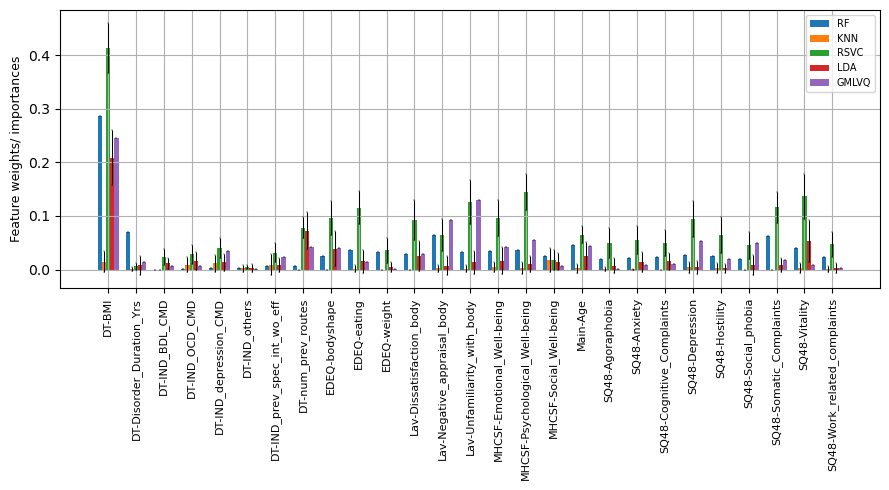

In [92]:
select_keys1=['RF', 'KNN','RSVC', 'LDA','GMLVQ']
select_keys2=['GNB','LGMLVQ', 'LogLASSO']
fs=9
exp_name=save_dict[2.2]
X=dataset_types[2.2]['mice_zXtrain']
fimp_all=fimp_all_exps[2.2]
adapted_combo_cols=X.columns
ind = np.arange(len(adapted_combo_cols))  # the x locations for the groups
width = 0.15  # the width of the bars
shifts=[-0.3,-0.15,0.0,0.15,0.30]
fig, ax = plt.subplots(1,1, figsize=(9,5))
rects_all={}
for idx,key in enumerate(select_keys1):
    bardata, err=np.mean(fimp_all[key]['All'], axis=1), np.std(fimp_all[key]['All'], axis=1)
    rects_all[key] = ax.bar(ind +shifts[idx], bardata, width, yerr=err, label=key, 
                           error_kw=dict(lw=0.75, capsize=0.5, capthick=0.3))
ax.set_ylabel('Feature weights/ importances', fontsize=fs)
#ax.set_title('Scores by group and gender')
ax.set_xticks(ind)
ax.set_xticklabels(adapted_combo_cols, rotation=90, fontsize=fs-1)
ax.legend(fontsize=fs-2)
ax.grid()
fig.tight_layout()
plt.show()
fig.savefig('figs/PDFs/classification/FIMP1%s.pdf'%exp_name, bbox_inches='tight', transparent=False,
               pad_inches=0.01)
fig.savefig('figs/PNGs/classification/FIMP1_%s.png'%exp_name, bbox_inches='tight', transparent=True,
               pad_inches=0.01)

In [75]:
print(pipeClassifiers['GNB'][0]['GNB'].classes_)
print(pipeClassifiers['LGMLVQ'][0]['LGMLVQ'].classes_)
print(pipeClassifiers['LogLASSO'][0]['LogLASSO'].classes_)


['Anorexia nervosa' 'Binge-ED' 'Bulimia nervosa' 'Other ED' 'Others']
['Anorexia nervosa' 'Binge-ED' 'Bulimia nervosa' 'Other ED' 'Others']
['Anorexia nervosa' 'Binge-ED' 'Bulimia nervosa' 'Other ED' 'Others']


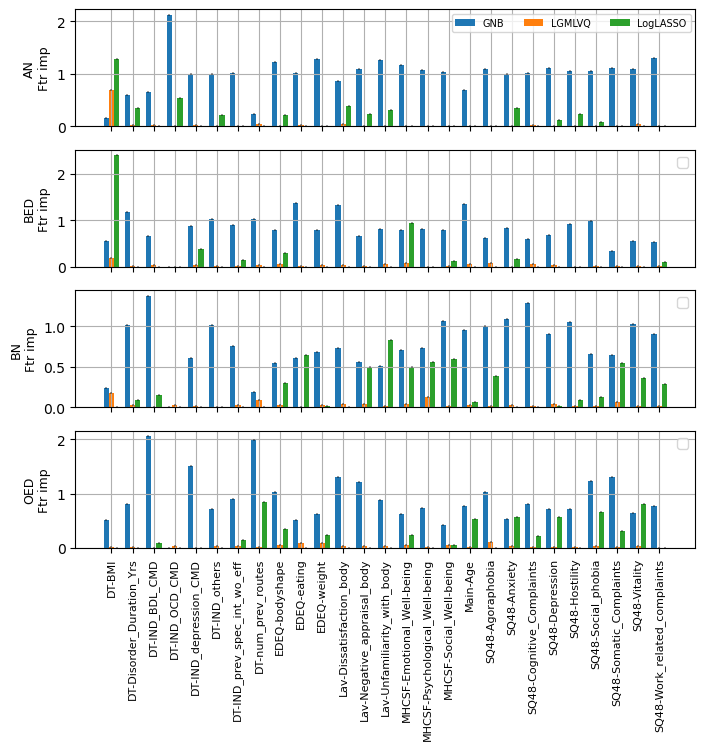

In [93]:
select_keys2=['GNB','LGMLVQ', 'LogLASSO']
Cls_dict=dict(zip(pipeClassifiers['GNB'][0]['GNB'].classes_, ['AN','BED','BN', 'OED', 'Others']))
fs=9
ind = np.arange(len(adapted_combo_cols))  # the x locations for the groups
width = 0.25  # the width of the bars
#shifts=[-0.48, -0.33,-0.167, 0.167,0.33,0.48]
shifts=[-0.25,0.0,0.25]
fig1, ax1 = plt.subplots(nclasses,1, figsize=(8,7), sharex=True)
rects_all={}
#fimp_all['GNB']['C1']
for cls in range(0, nclasses):
    for idx,key in enumerate(select_keys2):
        clsName=pipeClassifiers[key][0][key].classes_[cls]
        bardata, err=np.mean(fimp_all[key]['C%d'%(cls+1)]['All'], axis=1), np.std(fimp_all[key]['C%d'%(cls+1)]['All'], axis=1)
        rects_all[key] = ax1[cls].bar(ind +shifts[idx], bardata, width, yerr=err, label=key, 
                           error_kw=dict(lw=0.75, capsize=0.5, capthick=0.3))
# Add some text for labels, title and custom x-axis tick labels, etc.
    ax1[cls].set_ylabel('%s\nFtr imp'%Cls_dict[clsName], fontsize=fs)
    ax1[cls].grid()
    if cls==nclasses-1:
        ax1[cls].set_xticks(ind)
        ax1[cls].set_xticklabels(adapted_combo_cols, rotation=90, fontsize=fs-1)
    else:
       # ax1[cls].set_xticks([])
        ax1[cls].set_xticklabels([])
        #ax1[cls].tick_params(bottom=False)
    if cls==0:
        ax1[cls].legend(fontsize=fs-2, loc='upper right', ncol=3)
    else:
        ax1[cls].legend('')
fig.tight_layout()
plt.show()
fig1.savefig('figs/PDFs/classification/FIMP2_%s.pdf'%exp_name, bbox_inches='tight', transparent=False,\
               pad_inches=0.01)
fig1.savefig('figs/PNGs/classification/FIMP2_%s.png'%exp_name, bbox_inches='tight', transparent=False,\
               pad_inches=0.01)

In [96]:
print(np.shape(prots_lvq_all[2.2]['LGMLVQ']['All']))
print(np.shape(prots_lvq_all[2.2]['GMLVQ']['All']))

(8, 27, 5)
(7, 27, 5)


In [ ]:
select_keys3=['GMLVQ','LGMLVQ']
Cls_dict=dict(zip(pipeClassifiers['GMLVQ'][0]['GMLVQ'].classes_, ['AN','BED','BN', 'OED', 'Others']))
fs=9
prot_val=prots_lvq_all[2.2]
ind = np.arange(len(adapted_combo_cols))  # the x locations for the groups
width = 0.25  # the width of the bars
#shifts=[-0.48, -0.33,-0.167, 0.167,0.33,0.48]
shifts=[-0.25,0.0,0.25]
fig3, ax3= plt.subplots(nclasses,1, figsize=(8,7), sharex=True)
rects_all={}
#fimp_all['GNB']['C1']
for cls in range(0, nclasses):
    for idx,key in enumerate(select_keys3):
        clsName=pipeClassifiers[key][0][key].classes_[cls]
        bardata, err=np.mean(prot_val[key]['C%d'%(cls+1)]['All'], axis=1), np.std(fimp_all[key]['C%d'%(cls+1)]['All'], axis=1)
        rects_all[key] = ax1[cls].bar(ind +shifts[idx], bardata, width, yerr=err, label=key, 
                           error_kw=dict(lw=0.75, capsize=0.5, capthick=0.3))
# Add some text for labels, title and custom x-axis tick labels, etc.
    ax1[cls].set_ylabel('%s\nFtr imp'%Cls_dict[clsName], fontsize=fs)
    ax1[cls].grid()
    if cls==nclasses-1:
        ax1[cls].set_xticks(ind)
        ax1[cls].set_xticklabels(adapted_combo_cols, rotation=90, fontsize=fs-1)
    else:
       # ax1[cls].set_xticks([])
        ax1[cls].set_xticklabels([])
        #ax1[cls].tick_params(bottom=False)
    if cls==0:
        ax1[cls].legend(fontsize=fs-2, loc='upper right', ncol=3)
    else:
        ax1[cls].legend('')
fig.tight_layout()
plt.show()
fig1.savefig('figs/PDFs/classification/FIMP2_%s.pdf'%exp_name, bbox_inches='tight', transparent=False,\
               pad_inches=0.01)
fig1.savefig('figs/PNGs/classification/FIMP2_%s.png'%exp_name, bbox_inches='tight', transparent=False,\
               pad_inches=0.01)

## Only ED classes

In [89]:
df_train_eds=df_adapted_combo[adapted_combo_cols].loc[(df_adapted_combo['Split']=='Train') & 
                    (~df_adapted_combo['EDtype'].str.contains('Others'))]
YTrain_eds=df_adapted_combo['EDtype'].loc[(df_adapted_combo['Split']=='Train') & 
                    (~df_adapted_combo['EDtype'].str.contains('Others'))]#.to_numpy()
df_test_eds=df_adapted_combo[adapted_combo_cols].loc[(df_adapted_combo['Split']=='Test') &
                   (~df_adapted_combo['EDtype'].str.contains('Others'))]
YTest_eds=df_adapted_combo['EDtype'].loc[(df_adapted_combo['Split']=='Test') & 
                    (~df_adapted_combo['EDtype'].str.contains('Others'))]#.to_numpy()

nan_mean=np.nanmean(df_train_eds.to_numpy(), axis=0)
nan_std=np.nanstd(df_train_eds.to_numpy(), axis=0)
z_train_eds_nan=((df_train_eds.to_numpy()-nan_mean)/nan_std)
z_train_ed_df=pd.DataFrame(data=z_train_eds_nan, columns=adapted_combo_cols)
z_test_ed_df=pd.DataFrame(data=((df_test_eds.to_numpy()-nan_mean)/nan_std), columns=adapted_combo_cols)

kernel_mm= mf.ImputationKernel(data=z_train_ed_df,num_datasets=1,mean_match_candidates=5)
kernel_mm.mice(10)
z_train_eds=pd.DataFrame(data=kernel_mm.complete_data(), columns=adapted_combo_cols)
temp_test=kernel_mm.impute_new_data(z_test_ed_df)
z_test_eds=pd.DataFrame(data=temp_test.complete_data(), columns=adapted_combo_cols)

sc2=StandardScaler().fit(z_train_eds)
zX_ed, zXtest_ed=sc2.transform(z_train_eds), sc2.transform(z_test_eds)
sm2=SMOTE(sampling_strategy=sampling_strategy)
X_ed,Y_ed=sm2.fit_resample(zX_ed, YTrain_eds)

In [100]:
iters=5
savepicklpath='%s/pickles/'%(os.getcwd())
dataset_type='Core_DT-ED'
model_fname='cls-%s.pkl'%dataset_type
modelsClassify1='%s%s'%(savepicklpath, model_fname)
modelsClassify1_permut='%s%s_%s'%(savepicklpath,dataset_type, 'permImp')
if os.path.exists(modelsClassify1):
    pipeClassifiers = pickle.load(open(modelsClassify1, "rb"))
    permut_model=pickle.load(open('%s.pkl'%modelsClassify1_permut, "rb"))
    print('Loading final ED-class Classification models complete')
else:
    g_num_prots, l_num_prots=np.array([3,2,1,1]), np.array([2,1,2,1])
    pipeRF=Pipeline(steps=[('RF', RandomForestClassifier(criterion="gini", min_samples_leaf=5,
                        class_weight='balanced_subsample', n_estimators=500, max_features=7))])
    pipeKNN=Pipeline(steps=[('KNN', KNeighborsClassifier(n_neighbors=3,metric='cosine'))])
    pipeLDA=Pipeline(steps=[('LDA', LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto'))])
    pipeQDA=Pipeline(steps=[('QDA', QuadraticDiscriminantAnalysis(reg_param=0.1))])
    pipeLSVC=Pipeline(steps=[('LSVC', SVC(kernel="linear", C=100))])
    pipeRSVC=Pipeline(steps=[('RSVC', SVC(kernel='rbf', C=10, gamma=0.01))])
    pipeLGMLVQ=Pipeline(steps=[('LGMLVQ', LGMLVQ(distance_type='local-adaptive-squared-euclidean', 
            prototype_n_per_class=np.array([2,1,2,1]), activation_type='identity',
            relevance_n_components=20,relevance_localization="prototypes", solver_type='lbfgs'))])
    pipeGMLVQ=Pipeline(steps=[('GMLVQ', GMLVQ(distance_type='adaptive-squared-euclidean', 
                prototype_n_per_class=np.array([3,2,1, 1]), relevance_regularization=0.001,
                activation_type='swish',relevance_n_components=20, solver_type='lbfgs'))])
    pipeGNB=Pipeline(steps=[('GNB', GaussianNB())])
    pipeLogLASSO=Pipeline(steps=[('LogLASSO',LogisticRegressionCV(Cs=[0.0001,0.001,0.01,0.1,1], solver='saga',
                class_weight='balanced', cv=5,penalty='l1', scoring=make_scorer(lowest_cwacc)))])
    pipeClassifiers={'RF':pipeRF, 'KNN':pipeKNN, 'LDA':pipeLDA, 'QDA': pipeQDA, 'LSVC': pipeLSVC, 
                 'RSVC': pipeRSVC, 'LGMLVQ': pipeLGMLVQ, 'GMLVQ': pipeGMLVQ, 'GNB': pipeGNB,
                'LogLASSO':pipeLogLASSO}
    use_permutation_imp=['KNN','LDA','QDA','LSVC','RSVC']
    permut_model, nreps={},10
    for key, clf in pipeClassifiers.items():
        clf_all, temp=[],{}
        for iter in range(iters):
            clf.fit(X_ed, Y_ed)
            clf_all.append(clf)
            if key in use_permutation_imp:
                permimp = permutation_importance(clf, X_ed, Y_ed, n_repeats=nreps, scoring=make_scorer(lowest_cwacc))
                temp[iter]=permimp.importances
        if key in use_permutation_imp:
            permut_model[key]=temp#importances=>shape (n_features, n_repeats)
        pipeClassifiers[key]=clf_all
    print('Training final ED-class Classification models complete')
    with open(modelsClassify1, 'wb') as f:  # open a text file
        pickle.dump(pipeClassifiers, f) 
    with open('%s.pkl'%modelsClassify1_permut, 'wb') as f:  # open a text file
        pickle.dump(permut_model, f) 
    print('Saving final ED-class Classification models complete')
nclasses=len(np.unique(YTrain_eds))
labs=np.unique(YTrain_eds)
train_conf_all, test_conf_all, classifiers_all={},{},{}

Training final ED-class Classification models complete
Saving final ED-class Classification models complete


In [106]:
#print(clf['GNB'])
print(list(pipeClassifiers.keys()))
print(pipeClassifiers['GNB'][0]['GNB'])

['RF', 'KNN', 'LDA', 'QDA', 'LSVC', 'RSVC', 'LGMLVQ', 'GMLVQ', 'GNB', 'LogLASSO']
GaussianNB()


In [97]:
use_permutation_imp, nreps=list(permut_model.keys()),10
num_features, iters=df_train_adapted.shape[1],5
prots_lvq, fimp_all={},{}
for key, clf in pipeClassifiers.items():
    tr_cmap=np.zeros((nclasses, nclasses, iters))
    te_cmap=np.zeros((nclasses, nclasses, iters))
    if (key=='GMLVQ') | (key=='LGMLVQ'):    
        all_prots=np.zeros((clf[0][key].prototypes_.shape[0], num_features, iters))
    if (key=='LGMLVQ') | (key=='GNB'):
        all_ftr_vars=np.zeros((nclasses, num_features, iters))
    elif key in use_permutation_imp:
        all_ftr_vars=np.zeros((num_features,nreps, iters))    
    else:
        all_ftr_vars=np.zeros((num_features, iters))#rel_diag=np.diagonal(clf[iter][key].lambda_.T   
    for iter in range(iters):  
        if key=='GMLVQ':
            all_ftr_vars[:,iter]=np.diagonal(clf[iter][key].lambda_)
        elif key=='RF':
            all_ftr_vars[:,iter]=clf[iter][key].feature_importances_
        elif key=='LGMLVQ':
            cwRel=[]
            for x in range(nclasses): cwRel.append(np.diagonal(clf[iter][key].lambda_[x]))
            all_ftr_vars[:,:,iter]=cwRel
        elif (key=='GNB'):
            print(key, np.shape(cwRel))
            all_ftr_vars[:,:,iter]=clf[iter][key].var_
        elif key=='LogLASSO':
            all_ftr_vars[:,iter]=clf[iter][key].coef_[np.where(clf[iter][key].Cs_==clf[iter][key].C_)[0]]
        else:
            all_ftr_vars[:,:,iter]=permut_model[key][iter]
        if (key=='GMLVQ') | (key=='LGMLVQ'):    
            all_prots[:,:,iter]=clf[iter][key].prototypes_            
        train_pred_labs=clf[iter][key].predict(zX_ed)
        test_pred_labs=clf[iter][key].predict(zXtest_ed)
        tr_cmap[:,:,iter]=confusion_matrix(YTrain_eds, train_pred_labs, normalize='true', labels=labs)
        te_cmap[:,:,iter]=confusion_matrix(YTest_eds, test_pred_labs, normalize='true', labels=labs)
        train_conf_all[key], test_conf_all[key]=tr_cmap, te_cmap
    if key in ['GMLVQ','LGMLVQ']:
        prots_lvq[key]={'Mean': np.mean(all_prots,axis=2), 'Std': np.std(all_prots,axis=2),
                       'All':all_prots}
    if key in use_permutation_imp:
        n_extended=all_ftr_vars.shape[1]* all_ftr_vars.shape[2]
        all_ftr_vars=np.reshape(all_ftr_vars,(num_features, n_extended))
        fimp_all[key]={'Mean': np.mean(all_ftr_vars, axis=1), 'Std':np.std(all_ftr_vars, axis=1),
                      'All': all_ftr_vars}
    elif key in ['RF', 'GMLVQ','LogLASSO']:
        fimp_all[key]={'Mean': np.mean(all_ftr_vars, axis=1), 'Std':np.std(all_ftr_vars, axis=1),
                      'All': all_ftr_vars}
    else:
        perClass={}
        for c in range(nclasses):
            perClass['C%d'%(c+1)]={'Mean': np.mean(all_ftr_vars[c,:,:]),
                 'Std': np.std(all_ftr_vars[c,:,:]),'All': all_ftr_vars[c,:,:]}
        fimp_all[key]=perClass
print(labs2)
train_conf_eds, test_conf_eds, classifiers_eds={},{},{}

GNB (4, 26)
GNB (4, 26)
GNB (4, 26)
GNB (4, 26)
GNB (4, 26)


ValueError: operands could not be broadcast together with shapes (5,) (4,) 

LogisticRegressionCV(Cs=[0.0001, 0.001, 0.01, 0.1, 1], class_weight='balanced',
                     cv=5, penalty='l1',
                     scoring=make_scorer(lowest_cwacc, response_method='predict'),
                     solver='saga')

In [14]:
num_prototypes=np.sum(np.array([1,1, 1]))
num_features, iters=df_train_eds.shape[1],5
all_relevance, all_prots=np.zeros((nclasses2, num_features, iters)), np.zeros((num_prototypes, num_features, iters))

for key, clf in pipeClassifiers2.items():
    tr_cmap=np.zeros((nclasses2, nclasses2, iters))
    te_cmap=np.zeros((nclasses2, nclasses2, iters))
    clf_all=[]
    for iter in range(iters):
        clf.fit(X_ed,Y_ed)
        clf_all.append(clf)
        train_pred_labs_eds=clf.predict(zX_ed)
        test_pred_labs_eds=clf.predict(zXtest_ed)
        tr_cmap[:,:,iter]=confusion_matrix(YTrain_eds, train_pred_labs_eds, normalize='true', labels=labs2)
        te_cmap[:,:,iter]=confusion_matrix(YTest_eds, test_pred_labs_eds, normalize='true', labels=labs2)
    classifiers_eds[key]=clf_all
    train_conf_eds[key], test_conf_eds[key]=tr_cmap, te_cmap
    cmap_dict={'Training': tr_cmap, 'Test':te_cmap}
    for split_set in ['Training', 'Test']:
        print(key+'-'+split_set)    
        if split_set=='Training':
            printlabs=[]
            for lab in labs2:
                if (lab==labs2[2]): # | (lab==labs2[3]):
                    printlabs.append('    '+lab)
                else:
                    printlabs.append(lab)
            print(printlabs)
        mean_glob, std_glob=cmap_dict[split_set].mean(axis=2), cmap_dict[split_set].std(axis=2)
        disp_num_glob=np.reshape(np.stack((mean_glob, std_glob)).ravel('F'),(nclasses2,2*nclasses2))
        for idx in range(nclasses2):
            cmap_cell=[]
            for jdx in range(nclasses2):
                cmap_cell.append('%.3f (%.3f) '%(mean_glob[idx,jdx], std_glob[idx,jdx]))
            print(cmap_cell)    

RF-Training
['Anorexia nervosa', 'Binge-ED', '    Bulimia nervosa', 'Other ED']
['0.994 (0.011) ', '0.006 (0.011) ', '0.000 (0.000) ', '0.000 (0.000) ']
['0.000 (0.000) ', '1.000 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ']
['0.154 (0.000) ', '0.000 (0.000) ', '0.846 (0.000) ', '0.000 (0.000) ']
['0.000 (0.000) ', '0.059 (0.000) ', '0.106 (0.024) ', '0.835 (0.024) ']
RF-Test
['0.662 (0.031) ', '0.237 (0.025) ', '0.000 (0.000) ', '0.100 (0.031) ']
['0.000 (0.000) ', '0.625 (0.000) ', '0.125 (0.000) ', '0.250 (0.000) ']
['0.667 (0.000) ', '0.200 (0.163) ', '0.000 (0.000) ', '0.133 (0.163) ']
['0.200 (0.000) ', '0.200 (0.000) ', '0.080 (0.098) ', '0.520 (0.098) ']
KNN-Training
['Anorexia nervosa', 'Binge-ED', '    Bulimia nervosa', 'Other ED']
['0.714 (0.000) ', '0.029 (0.000) ', '0.114 (0.000) ', '0.143 (0.000) ']
['0.000 (0.000) ', '0.900 (0.000) ', '0.050 (0.000) ', '0.050 (0.000) ']
['0.077 (0.000) ', '0.000 (0.000) ', '0.846 (0.000) ', '0.077 (0.000) ']
['0.000 (0.000) ', '0.000 (0

# Regression
### In regression, the closer the R2 score is to 1 the better is the model's performance, and the closer RMSE is to 0, the better is teh performance

## Regression (all classes)

In [15]:
#df_train_adapted=df_adapted_combo[adapted_combo_cols].loc[df_adapted_combo['Split']=='Train']
YTrain_reg=df_adapted_combo['EDEQ-Score'].loc[df_adapted_combo['Split']=='Train']#.to_numpy()
#df_test_adapted=df_adapted_combo[adapted_combo_cols].loc[df_adapted_combo['Split']=='Test']
YTest_reg=df_adapted_combo['EDEQ-Score'].loc[df_adapted_combo['Split']=='Test']

In [16]:
iters=5
pipeRFreg=Pipeline(steps=[('RF', RandomForestRegressor(criterion="poisson", min_samples_leaf=5,
                                                       n_estimators=100, max_features=25))])
pipeKNNreg=Pipeline(steps=[('KNN', KNeighborsRegressor(n_neighbors=5,metric='cosine'))])
pipeLSVR=Pipeline(steps=[('LinSVC', SVR(kernel="linear", C=0.01))])
pipeRSVR=Pipeline(steps=[('RbfSVC', SVR(kernel='rbf', C=1, gamma=0.01))])
pipeLASSO=Pipeline(steps=[('LASSO', LassoCV(cv=5))])
pipeRegressors={'RF':pipeRFreg, 'KNN':pipeKNNreg, 'LSVC': pipeLSVR, 'RSVC': pipeRSVR, 'LASSOReg': pipeLASSO}

In [17]:
num_features, iters=df_train_eds.shape[1],5
all_relevance=np.zeros((nclasses2, num_features, iters))
perf_dict, regressor_all, train_perf_all, test_perf_all={},{},{},{}
for key, reg in pipeRegressors.items():
    tr_perf=np.zeros((2, iters))
    te_perf=np.zeros((2, iters))
    reg_all=[]
    for iter in range(iters):
        reg.fit(z_train_explore, YTrain_reg)
        reg_all.append(reg)
        train_pred_labs_eds=reg.predict(z_train_explore)
        test_pred_labs_eds=reg.predict(z_test_explore)
        tr_perf[0,iter]=r2_score(YTrain_reg, train_pred_labs_eds)
        te_perf[0,iter]=r2_score(YTest_reg, test_pred_labs_eds)
        tr_perf[1,iter]=root_mean_squared_error(YTrain_reg, train_pred_labs_eds)
        te_perf[1,iter]=root_mean_squared_error(YTest_reg, test_pred_labs_eds)
    regressor_all[key]=reg_all
    train_perf_all[key], test_perf_all[key]=tr_perf, te_perf
    perf_dict[key+'Training']={'R2(mean)': np.mean(tr_perf[0,:]),'R2(std)': np.std(tr_perf[0,:]),
                    'RMSE(mean)': np.mean(tr_perf[1,:]),'RMSE(std)': np.std(tr_perf[1,:])}
    perf_dict[key+'Test']={'R2(mean)': np.mean(te_perf[0,:]),'R2(std)': np.std(te_perf[0,:]),
                          'RMSE(mean)': np.mean(te_perf[1,:]),'RMSE(std)': np.std(te_perf[1,:])}
    for split in ['Training', 'Test']:
        print('%s %s: R2= %.3f (%.3f), RMSE= %.3f (%.3f)'%(key, split,
                    perf_dict[key+split]['R2(mean)'], perf_dict[key+split]['R2(std)'],
                    perf_dict[key+split]['RMSE(mean)'], perf_dict[key+split]['RMSE(std)']))
#print(perf_dict)

RF Training: R2= 0.756 (0.004), RMSE= 0.589 (0.005)
RF Test: R2= 0.461 (0.029), RMSE= 0.861 (0.023)
KNN Training: R2= 0.582 (0.000), RMSE= 0.770 (0.000)
KNN Test: R2= 0.261 (0.000), RMSE= 1.008 (0.000)
LSVC Training: R2= 0.490 (0.000), RMSE= 0.850 (0.000)
LSVC Test: R2= 0.358 (0.000), RMSE= 0.939 (0.000)
RSVC Training: R2= 0.566 (0.000), RMSE= 0.785 (0.000)
RSVC Test: R2= 0.408 (0.000), RMSE= 0.902 (0.000)
LASSOReg Training: R2= 0.542 (0.000), RMSE= 0.806 (0.000)
LASSOReg Test: R2= 0.504 (0.000), RMSE= 0.826 (0.000)


## Regression (only ED classes)

In [19]:
#df_train_eds=df_adapted_combo[adapted_combo_cols].loc[(df_adapted_combo['Split']=='Train') & (df_adapted_combo['EDtype']!='Others')]
YTrain_reg_eds=df_adapted_combo['EDEQ-Score'].loc[(df_adapted_combo['Split']=='Train') & 
                        (df_adapted_combo['EDtype']!='Others')]#.to_numpy()
#df_test_eds=df_adapted_combo[adapted_combo_cols].loc[(df_adapted_combo['Split']=='Test') & (df_adapted_combo['EDtype']!='Others')]
YTest_reg_eds=df_adapted_combo['EDEQ-Score'].loc[(df_adapted_combo['Split']=='Test') &
                        (df_adapted_combo['EDtype']!='Others')]#.to_numpy()
iters=5
pipeRFreg2=Pipeline(steps=[('RF', RandomForestRegressor(criterion="squared_error",
                    n_estimators=100, min_samples_leaf=5, max_features=20))])
pipeKNNreg2=Pipeline(steps=[('KNN', KNeighborsRegressor(n_neighbors=5,metric='cosine'))])
pipeLSVR2=Pipeline(steps=[('LinSVC', SVR(kernel="linear", C=0.1))])
pipeRSVR2=Pipeline(steps=[('RbfSVC', SVR(kernel='rbf', C=10, gamma=0.01))])
pipeLASSO2=Pipeline(steps=[('LASSO', LassoCV(cv=5))])
pipeRegressors2={'RF':pipeRFreg2, 'KNN':pipeKNNreg2, 'LSVC': pipeLSVR2, 'RSVC': pipeRSVR2, 'LASSO': pipeLASSO2}

num_features, iters=df_train_eds.shape[1],5
perf_dict2, regressor_all2, train_perf_all2, test_perf_all2={},{},{},{}
for key, reg in pipeRegressors2.items():
    tr_perf=np.zeros((2, iters))
    te_perf=np.zeros((2, iters))
    reg_all=[]
    for iter in range(iters):
        reg.fit(zX_ed, YTrain_reg_eds)
        reg_all.append(reg)
        train_pred_labs_eds=reg.predict(zX_ed)
        test_pred_labs_eds=reg.predict(zXtest_ed)
        tr_perf[0,iter]=r2_score(YTrain_reg_eds, train_pred_labs_eds)
        te_perf[0,iter]=r2_score(YTest_reg_eds, test_pred_labs_eds)
        tr_perf[1,iter]=root_mean_squared_error(YTrain_reg_eds, train_pred_labs_eds)
        te_perf[1,iter]=root_mean_squared_error(YTest_reg_eds, test_pred_labs_eds)
    regressor_all2[key]=reg_all
    train_perf_all2[key], test_perf_all2[key]=tr_perf, te_perf
    perf_dict2[key+'Training']={'R2(mean)': np.mean(tr_perf[0,:]),'R2(std)': np.std(tr_perf[0,:]),
                    'RMSE(mean)': np.mean(tr_perf[1,:]),'RMSE(std)': np.std(tr_perf[1,:])}
    perf_dict2[key+'Test']={'R2(mean)': np.mean(te_perf[0,:]),'R2(std)': np.std(te_perf[0,:]),
                          'RMSE(mean)': np.mean(te_perf[1,:]),'RMSE(std)': np.std(te_perf[1,:])}
    for split in ['Training', 'Test']:
        print('%s %s: R2= %.3f (%.3f), RMSE= %.3f (%.3f)'%(key, split,
                    perf_dict2[key+split]['R2(mean)'], perf_dict2[key+split]['R2(std)'],
                    perf_dict2[key+split]['RMSE(mean)'], perf_dict2[key+split]['RMSE(std)']))


RF Training: R2= 0.739 (0.005), RMSE= 0.616 (0.006)
RF Test: R2= 0.417 (0.013), RMSE= 0.898 (0.010)
KNN Training: R2= 0.585 (0.000), RMSE= 0.777 (0.000)
KNN Test: R2= 0.165 (0.000), RMSE= 1.075 (0.000)
LSVC Training: R2= 0.573 (0.000), RMSE= 0.788 (0.000)
LSVC Test: R2= 0.423 (0.000), RMSE= 0.893 (0.000)
RSVC Training: R2= 0.890 (0.000), RMSE= 0.400 (0.000)
RSVC Test: R2= 0.475 (0.000), RMSE= 0.852 (0.000)
LASSO Training: R2= 0.519 (0.000), RMSE= 0.837 (0.000)
LASSO Test: R2= 0.485 (0.000), RMSE= 0.844 (0.000)


In regression there does not seem to be relevant performance boost by exclusion of the non-ED class patients